<h1 style="text-align:center; color:#e64500ff;">Predict Return(CPI)</h1>

试了年度收益率的预测，试了试cpi最长能预测大概8月

In [1056]:
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
# import pymysql  # 导入数据库模块

from datetime import datetime # 时间模块
import statsmodels.formula.api as smf  # OLS regression

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates


from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
#mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family'] = 'Times New Roman'


#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

In [1057]:
from pandas.tseries.offsets import MonthEnd # 月末
Market_ret = pd.read_csv('./Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0) #原数据为：缩写的月份名称 年份 改成xxxx-xx-xx
Market_ret.set_index('month', inplace=True)
Market_ret.sort_index(inplace=True)
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [1058]:
inflation = pd.read_csv('./inflation.csv')
inflation['month'] = pd.to_datetime(inflation['month'],format='%Y/%m/%d')
inflation.set_index('month',inplace=True)
inflation

,cpi
month,
1987-01-31,5.1
1987-02-28,5.4
1987-03-31,5.8
1987-04-30,6.7
1987-05-31,7.6
...,...
2025-03-31,-0.1
2025-04-30,-0.1
2025-05-31,-0.1



<font size="6" color=#87CEEB>✨月度数据的预测✨</font>   
检验收益率可预测性最常用的计量经济学方法，是将资产收益率对一个或几个滞后预测变量进行简单线性回归。为简化起见，考虑将第$(t+1)$期股票市场收益率$r_{t+1}$对单一预测变量$x_t$进行单变量预测回归。
 $$
r_{t+1}=\alpha+\beta x_{t}+\varepsilon_{t+1}
$$
其中$\varepsilon_{t+1}$是均值为零的不可预测扰动项。当$x_t$为通货膨胀率、股息收益率、账面市值比或换手率时，众多研究者发现$\beta$显著异于零——这表明存在股票市场收益率可预测性的样本内证据。


<font size="6" color=#87CEEB>✨模型： 通货膨胀与股票预期收益率✨</font>   

$$
r_{t+1} = \alpha + \beta*CPI_{t-1} + \varepsilon_{t+1}
$$
<font size="4" color=#e64500ff>由于CPI数据统计需要时间，往往获取不到t期CPI，而通过t-1期数据预测</font>
> 名义收益率 ≈ 真实收益率 + 预期通货膨胀率

如果我们将这个逻辑应用到股票上，并假设股票的预期真实收益率是相对稳定的（因为它由经济体的基本生产力、风险偏好等真实变量决定），  
那么预期名义股票收益率应该随着预期通货膨胀率的上升而上升。这意味着，股票作为对公司实物资产（厂房、设备、存货）所有权的代表，  
其名义价值应该能够对冲通胀带来的货币贬值，从而保持其真实价值。 
### **一、 通货膨胀与预期股票收益率的正相关关系论述**
1.  **理论逻辑：股票作为通胀的对冲工具（Inflation Hedge）**
    *   **基本原理**：股票代表的是对公司所有权的索取权，而公司的价值根本上来自于其拥有的实物资产（Real Assets）和未来的盈利能力。  
    <font size="4" color=#e64500ff>在通胀环境下，产品和服务的价格会上涨，公司的名义收入和名义利润也随之增加。同时，公司拥有的厂房、土地、存货等实物资产的名义价值也会重估上升。  
    因此，从理论上讲，股票的内在价值应该与物价水平同步上涨，从而使其名义收益率能够补偿通货膨胀带来的损失，保证投资者的真实回报。</font> 
2.  **实证支持：长期视角下的发现**
    *   早期的许多研究未能发现正相关关系，但这可能与研究的时间窗口有关。**[Boudoukh 和 Richardson (1993)](https://www.jstor.org/stable/2117566)** 的研究是一个重要的转折点。  
    他们通过使用更长的时间序列数据（从19世纪至今），发现当考察的持有期越长（例如5年或更长），股票收益率与通货膨胀之间的正相关关系就越显著。 
    *   **结论启示**：他们的研究表明，股票在短期内可能不是一个好的通胀对冲工具，<font size="4" color=#e64500ff>但在长期来看，其作为实物资产的保值属性会逐渐显现。</font>  
    这暗示了市场在短期内可能存在定价偏差或反应不足，但在长期会回归其基本面价值。  
### **二、 通货膨胀与预期股票收益率的负相关关系论述**
1.  **理论逻辑与解释**
    *   **税收效应（Tax Effect）**：这是最经典的解释之一。大多数国家的税法是基于**名义利润**和**名义资本利得**来征税的，而不是真实利润或真实资本利得。  
        *   **折旧**：在通胀期间，基于历史成本计算的设备折旧额，其真实价值会缩水，导致账面上的应税利润被高估。  
        *   **存货**：采用“先进先出”（FIFO）会计准则的公司，其销售成本会基于较早前购买的低成本存货，而收入则是按当前的高价格计算，这同样会虚增名义利润。  
        *   **资本利得税**：投资者卖出股票时，需要为名义上的价差缴税。即使股票价格的上涨仅仅是为了补偿通胀（真实收益为零），投资者依然要为这部分“虚假”的收益纳税。  
        这些税收上的扭曲效应，<font size="4" color=#e64500ff>使得通货膨胀侵蚀了公司的真实税后利润和投资者的真实税后收益，从而降低了股票的吸引力，导致其价格下跌（即预期收益率与通胀负相关）。</font>   
 
    *   **货币幻觉（Money Illusion）**：由诺贝尔奖得主 **Modigliani 和 Cohn (1979)** 提出的著名假说。他们认为，投资者在评估股票价值时会犯两个系统性错误：  
        1.  **错误的折现率**：投资者在用现金流折现模型估值时，倾向于使用名义利率去折现公司的真实现金流（未根据通胀调整的现金流），  
        或者<font size="4" color=#e64500ff>未能将公司因通胀而增加的债务价值</font>（真实负债减少）考虑在内。这导致他们系统性地低估了股票的价值。  
        2.  **对盈利质量的误判**：投资者看到了公司报告的名义利润在增长，<font size="4" color=#e64500ff>但未能充分认识到，在高通胀环境下，  
        维持同样生产能力所需的资本重置成本也在急剧上升。</font>因此，报告的利润质量实际上是下降的。  
        由于这种普遍存在的“货币幻觉”，当通胀上升时，市场会错误地压低股价。  

    *   **代理假说（Proxy Hypothesis）**：这是另一位诺贝尔奖得主 **Fama (1981)** 提出的一个更精巧的理论。  
    他认为，股票收益率和通货膨胀之间的负相关关系是<font size="4" color=#e64500ff>“伪相关”（Spurious Correlation），两者本身没有直接的因果联系。</font>真正的关系是：  
        1.  股票收益率与**未来的实体经济活动**（如工业产出、GDP增长）**正相关**。因为股市是经济的晴雨表。  
        2.  通货膨胀率与**未来的实体经济活动**则呈现**负相关**。这在当时被称为“滞胀”（Stagflation）现象，即高通胀往往预示着未来经济的衰退。  
        3.  因此，股票收益率和通货膨胀率，因为它们都与同一个变量（未来经济活动）相关，但方向相反，从而表现出了表观上的负相关关系。<font size="4" color=#e64500ff>通胀只是实体经济活动的“代理变量”。</font>  

    *   **风险溢价与不确定性（Risk Premium & Uncertainty）**：高通胀时期往往伴随着更高的经济不确定性和政策不确定性（例如，央行会如何应对）。  
    为了补偿这种增加的系统性风险，投资者会要求更高的风险溢价。在短期内，要求更高的预期回报率意味着更低的当前价格。因此，通胀的上升通过增加风险溢价，导致了当前股价的下跌。  

2.  **实证支持：里程碑式的研究**
    *   **[Fama 和 Schwert (1977)](https://doi.org/10.1016/0304-405X(77)90014-9)** 的研究是该领域的里程碑。他们检验了1953-1971年的美国数据，发现股票收益率与预期通胀、未预期通胀以及通胀变化都存在显著的负相关关系。他们明确指出，股票在那个时期是一个“坏”的通胀对冲工具，其表现甚至不如短期国债。这项研究的结论主导了学术界很长一段时间的看法。


In [1059]:
#merge函数用于合并，保留 Market_ret 的所有行，只从 inflation 中添加匹配的行
reg_data = pd.merge(Market_ret, inflation, left_index=True, right_index=True,how='left')
reg_data

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,cpi
month,,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1,2.2
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1,1.0
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1,1.6
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2,1.3
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2,3.6
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3,0.6
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3,0.4
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4,0.3


In [1060]:
# 导出数据
reg_data.to_csv('./reg_data.csv')
# 以excel格式保存,不推荐慢 reg_data.to_excel('./reg_data.xlsx')

In [1061]:
#取2000年后数据
reg_data = reg_data['2000':]


<font size="6" color=#87CEEB>作图</font>  
观察好像是反比关系

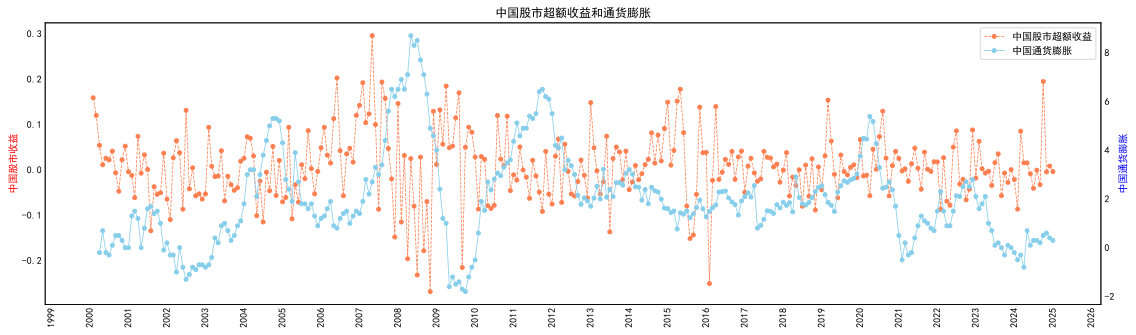

In [1062]:
#中国股市超额收益和通货膨胀图
fig, ax1 = plt.subplots(figsize=(15,4)) #长宽
plt.rcParams['font.sans-serif'] = ['SimHei']  #设置中文字体
plt.rcParams['axes.unicode_minus'] = False  #解决负号问题
ax1.plot(reg_data['ret'],color='coral',marker='o',linewidth=0.8,
         markersize=4,
         linestyle='--',label='中国股市超额收益') #虚线
ax1.set_ylabel('中国股市收益',color='red')
#ax1.set_xlabel('Month')

# 设置x轴的日期显示格式，必须在画第一张子图后就处理横坐标，不能放在画第二张后
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式，转至90度
plt.xticks(rotation = 90)

ax2 = ax1.twinx() #tiwnx创建共享 x 轴的双 y 轴图表
ax2.plot(reg_data['cpi'].shift(2),color='skyblue',marker='o',linewidth=0.8,  #shift(2)滞后两期
         markersize=4,
         linestyle='-',label='中国通货膨胀')

ax2.set_ylabel('中国通货膨胀',color='blue')

plt.title('中国股市超额收益和通货膨胀')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right') #图例，线条1、2，标识1、2，放的位置

#保存图片
fig.savefig('图/China Stock Market Return and Inflation.pdf',bbox_inches='tight') #bbox_inches='tight'自动调整保存图片的边界，确保所有内容都能完整地保存在图片中。

plt.show();

<font size="6" color=#87CEEB>描述性统计 Summary</font>

In [1063]:
# 主要变量（ret, cpi）的描述性统计
reg_data[['ret','cpi']].describe().round(5)

,ret,cpi
count,300.00000,300.00000
mean,0.00668,2.02053
std,0.07576,1.92313
min,-0.26835,-1.80000
25%,-0.03981,0.80150
50%,0.00603,1.80000
75%,0.04154,2.78695
max,0.29604,8.70000


In [1064]:
reg_data['ret'].skew()#偏度
reg_data['ret'].kurt()#峰度

np.float64(0.00767185990102763)

np.float64(1.7083227513566661)

In [1065]:
from statsmodels.tsa.stattools import adfuller as ADF

# 对月收益率数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(reg_data['ret'])

print('原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')  #这里空格把输出的%往后空

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')

原始序列的ADF检验结果:
ADF Statistic: -4.8575
p-value: 0.0000
Critical Values:
   1%: -3.4535
   5%: -2.8717
   10%: -2.5722
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


In [1066]:
# 对cpi数据进行ADF检验，输入数据平稳，可进行未来预测
adf_result = ADF(reg_data['2000':]['cpi'])
print('\n原始序列的ADF检验结果:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print('结论: p-value小于0.05，拒绝原假设，序列是平稳的。')
else:
    print('结论: p-value大于0.05，未能拒绝原假设，序列是非平稳的。')


原始序列的ADF检验结果:
ADF Statistic: -3.3288
p-value: 0.0136
Critical Values:
   1%: -3.4535
   5%: -2.8717
   10%: -2.5722
结论: p-value小于0.05，拒绝原假设，序列是平稳的。


<font size="6" color=#87CEEB>✨OLS 回归结果✨</font>  

In [1067]:
# Regression of return on inflation
reg_data['lcpi'] = reg_data['cpi'].shift(2)/100        #滞后2期，除一百还原百分比的通货膨胀
model_cpi = smf.ols('ret ~ lcpi',                      #smf.ols()调用包，'被解释变量 ~ 解释变量'
                 data=reg_data['2000-01':'2024-12']).fit(              #数据是什么，.fit拟合，cov_type='HAC', cov_kwds={'maxlags': 6}处理时间序列数据存在自相关或异方差问题
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi.summary())
#Dep. Variable 被解释变量
#Method: Least Squares 最小二乘法
#No. Observations 模型自由度
#R-squared R方，也称为决定系数，R方，模型的解释力，Adj. R-squared防止当模型中增加自变量时，R方会自然增大，统计学接受0.5%
#F-statistic F统计量，检验整个回归模型是否具有统计显著性
#Prob (F-statistic) 与F统计量对应的p值，由于p值（0.0142）小于常用的显著性水平0.05，认为这个回归模型在整体上是显著的
#coef (系数)它表示 lcpi 每增加1个单位，ret 平均会减少0.6663个单位。它们之间是负相关关系
#std err (标准误)  系数估计值的标准误差，衡量了系数估计的精确度。标准误越小，估计越精确。
#z z统计量，用于检验单个系数是否显著不为0。计算公式为 coef / std err
#P>|z|  与z统计量对应的p值。p值为0.014 < 0.05，说明 lcpi 的系数是显著的。
#[0.025 0.975] (95%置信区间) 对于 lcpi，其系数的95%置信区间为 [-1.196, -0.137]。这个区间完全为负数，进一步支持了 lcpi 与 ret 存在负相关关系的结论。
 

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.079
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0142
Time:                        19:55:29   Log-Likelihood:                 353.13
No. Observations:                 298   AIC:                            -702.3
Df Residuals:                     296   BIC:                            -694.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0193      0.007      2.673      0.0

C:\Users\user\AppData\Local\Temp\ipykernel_40372\1736916873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['lcpi'] = reg_data['cpi'].shift(2)/100        #滞后2期，除一百还原百分比的通货膨胀


In [1068]:
#检验上个月股票回报率是否有影响,会不会cpi是上个月股票回报率代理因素
reg_data['lret'] = reg_data['ret'].shift(1)
model_cpi_lag = smf.ols('ret ~ lcpi + lret',       #解释变量加入lret
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi_lag.summary())
#结果lret不显著0.198

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     6.839
Date:                Sat, 18 Oct 2025   Prob (F-statistic):            0.00125
Time:                        19:55:29   Log-Likelihood:                 355.07
No. Observations:                 298   AIC:                            -704.1
Df Residuals:                     295   BIC:                            -693.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0172      0.006      2.653      0.0

C:\Users\user\AppData\Local\Temp\ipykernel_40372\3667776498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['lret'] = reg_data['ret'].shift(1)


<font size="6" color=#87CEEB>预期收益率</font>

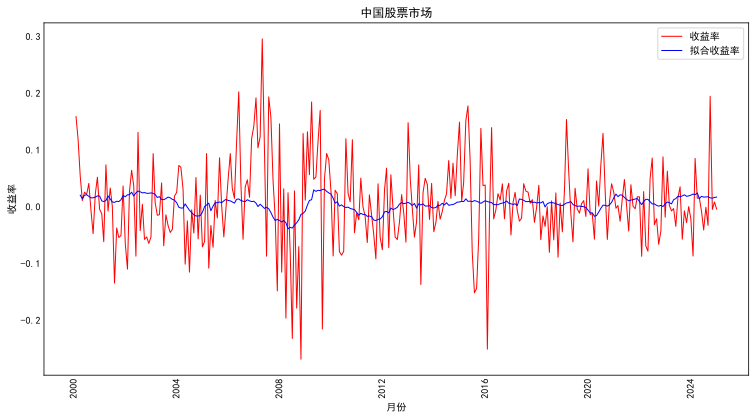

In [1069]:
#绘制预测收益率和实际收益率图
data = reg_data['2000-01':'2024-12'].copy()
data['fitted_return'] =  model_cpi.fittedvalues

fig = plt.figure(figsize=(10, 5))
plt.plot('ret',
         '-r',  #实线red
         label='收益率',
         linewidth=1,
         data=data)
plt.plot('fitted_return',
         '-b',   #实线blue
         label='拟合收益率',
         linewidth=1,
         data=data)
plt.title("中国股票市场")
plt.xlabel('月份')  # x轴名称
plt.ylabel('收益率')  # y轴名称

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())

# 转置x轴的日期显示格式(rotation = 90)
plt.xticks(rotation = 90)
plt.legend()
fig.savefig('图/fitted_return.pdf', bbox_inches='tight')  
plt.show();


<font size="6" color=#87CEEB>季度结果</font>

In [1070]:
#resample方法时间序列重采样，并处理ret，cpi数据
Q_reg_data = reg_data['1995-01':'2024-12'].resample('QE').apply({
    'ret':
    lambda x: (1 + x).prod() - 1,
    'cpi':
    lambda x: sum(x)
})
Q_reg_data['lag_cpi'] = Q_reg_data['cpi'].shift(1)
Q_reg_data

,ret,cpi,lag_cpi
month,,,
2000-03-31,0.368451,3.000000e-01,NaN
2000-06-30,0.059961,3.000000e-01,3.000000e-01
2000-09-30,-0.014135,8.000000e-01,3.000000e-01
2000-12-31,0.071593,2.800000e+00,8.000000e-01
2001-03-31,-0.004098,2.000000e+00,2.800000e+00
...,...,...,...
2023-12-31,-0.047820,-1.000000e+00,-2.000000e-01
2024-03-31,0.006789,-8.326673e-17,-1.000000e+00
2024-06-30,-0.034157,8.000000e-01,-8.326673e-17


In [1071]:
#查看可用的 matplotlib 样式
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

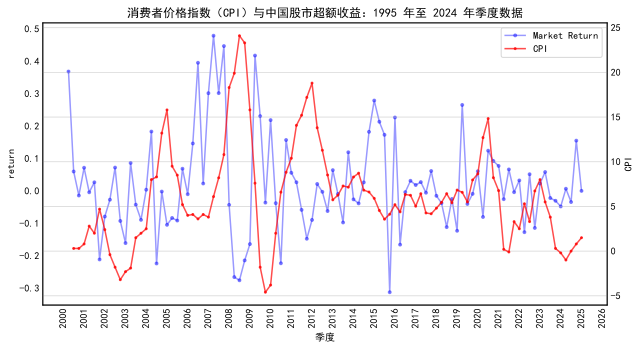

In [1072]:
# 更改图形样式 
plt.style.use('_mpl-gallery-nogrid')
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)  #(x, x, x)这里前两个表示几*几的网格，最后一个表示第几子图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
ax1.plot(Q_reg_data['ret'],
         color='blue',
         marker='.',
         linestyle='-',
         linewidth=1.5,
         markersize=6,
         alpha=0.4,
         label='Market Return')
ax1.set_xlabel('季度')  # 设置横坐标标签
ax1.set_ylabel('return')  # 设置左边纵坐标标签
#ax1.legend(loc=2)  # 设置图例在左上方
ax1.set_title("消费者价格指数（CPI）与中国股市超额收益：1995 年至 2024 年季度数据")  # 给整张图命名

# 设置x轴的日期显示格式
data_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(data_format)
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation = 90) # 转置x轴的日期显示格式

ax2 = ax1.twinx()  #twinx()函数表示共享x轴
ax2.plot(Q_reg_data['lag_cpi'],
         color='red',
         marker='o',
         linestyle='-',
         linewidth=1.5,
         markersize=2,
         alpha=0.7,
         label='CPI')
ax2.set_ylabel('CPI')  # 设置右边纵坐标标签
#ax2.legend(loc=1)  # 设置图例在右上方

# 设置标签
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.grid(True, alpha=0.5)#设置网格线
fig.savefig('Qcpi.pdf', bbox_inches='tight')
plt.show();

In [1073]:
#回归检验季度数据中cpi对收益率的影响
Q_reg_data['lcpi'] = Q_reg_data['cpi'].shift(1)
model_qcpi = smf.ols('ret ~ lcpi',
                 data=Q_reg_data['2000':'2024']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_qcpi.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     4.408
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0384
Time:                        19:55:30   Log-Likelihood:                 50.322
No. Observations:                  99   AIC:                            -96.64
Df Residuals:                      97   BIC:                            -91.45
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0564      0.023      2.420      0.0

In [1074]:
#加入控制量检验
Q_reg_data['lret'] = Q_reg_data['ret'].shift(1)
model_qcpi_lag = smf.ols('ret ~ lcpi + lret',
                 data=Q_reg_data['2000':'2024']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_qcpi_lag.summary())
#lret不显著 p值0.211

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.727
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0276
Time:                        19:55:30   Log-Likelihood:                 52.212
No. Observations:                  99   AIC:                            -98.42
Df Residuals:                      96   BIC:                            -90.64
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0455      0.019      2.409      0.0

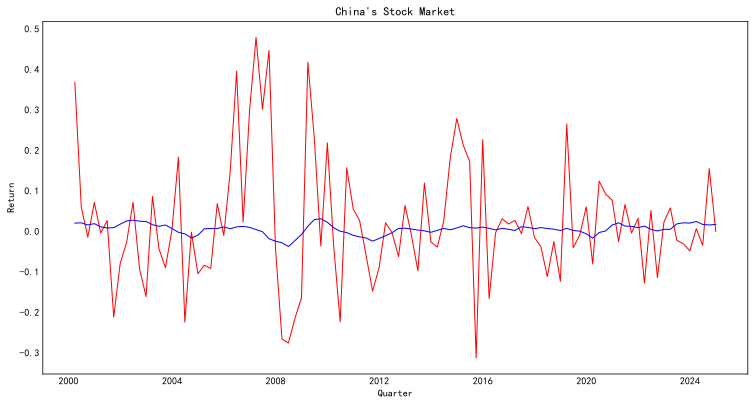

In [1075]:
#用季度数据绘制预测收益率和实际收益率图
data = Q_reg_data['2000-01':'2024-12'].copy()
data['fitted_return'] =  model_cpi.fittedvalues

fig = plt.figure(figsize=(10, 5))
plt.plot('ret',
         '-r',
         label='ret',
         linewidth=1,
         data=data)
plt.plot('fitted_return',
         '-b',
         label='Fitted Return',
         linewidth=1,
         data=data)
plt.title("China's Stock Market")
plt.xlabel('Quarter')  # 画图的x轴名称
plt.ylabel('Return')  # 画图的y轴名称

plt.show();

<font size="6" color=#87CEEB>年度结果</font>

In [1076]:
# 按年度重采样并计算年度收益率与CPI累计值
Y_reg_data = reg_data['1995-01':'2024-12'].resample('YE').apply({
    'ret':
    lambda x: (1 + x).prod() - 1,   # 年度收益率
    'cpi': 
    lambda x: x.sum()               # 年度CPI总和（或累计）
})

# 生成滞后一期CPI
Y_reg_data['lag_cpi'] = Y_reg_data['cpi'].shift(1)
Y_reg_data


,ret,cpi,lag_cpi
month,,,
2000-12-31,0.532381,4.2000,NaN
2001-12-31,-0.257318,8.7000,4.2000
2002-12-31,-0.205606,-9.2000,8.7000
2003-12-31,-0.048873,14.0000,-9.2000
2004-12-31,-0.179015,46.8000,14.0000
2005-12-31,-0.118946,21.8000,46.8000
2006-12-31,1.130165,17.6000,21.8000
2007-12-31,1.666144,57.2000,17.6000
2008-12-31,-0.650563,70.8000,57.2000


In [1077]:
# 计算年度滞后 CPI
Y_reg_data['lcpi'] = Y_reg_data['cpi'].shift(1)

# 建立年度回归模型（2000–2024年样本）
model_ycpi = smf.ols('ret ~ lcpi',
                     data=Y_reg_data['2000':'2024']).fit(
                         cov_type='HAC', cov_kwds={'maxlags': 1})

print(model_ycpi.summary())
#不显著，解释力差，不适合预测


                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.3733
Date:                Sat, 18 Oct 2025   Prob (F-statistic):              0.547
Time:                        19:55:30   Log-Likelihood:                -17.274
No. Observations:                  24   AIC:                             38.55
Df Residuals:                      22   BIC:                             40.90
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0466      0.170      0.274      0.7

<font size="6" color=#87CEEB>长期预测 Long Horizon Forecast</font>

$$
r_{t} + r_{t+1} + r_{t+2}  =\alpha+\beta x_{t}+\varepsilon_{t+1}
$$

In [1078]:
reg_data['next_ret'] = reg_data['ret'] + 1   #t月收益率
reg_data['next_ret2'] = reg_data['ret'].shift(-1) + 1  #t+1月收益率
reg_data['next_ret3'] = reg_data['ret'].shift(-2) + 1  #t+2月收益率
reg_data['future_3month_return'] = reg_data['next_ret'] * reg_data['next_ret2'] * reg_data['next_ret3'] - 1   #t、t+1、t+2月累计收益率

reg_data

C:\Users\user\AppData\Local\Temp\ipykernel_40372\271668575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['next_ret'] = reg_data['ret'] + 1   #t月收益率
C:\Users\user\AppData\Local\Temp\ipykernel_40372\271668575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['next_ret2'] = reg_data['ret'].shift(-1) + 1  #t+1月收益率
C:\Users\user\AppData\Local\Temp\ipykernel_40372\271668575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,MarketR,MarketR_e,rfmonth,ret,ret_e,marketret3,marketret6,marketret12,Q,cpi,lcpi,lret,next_ret,next_ret2,next_ret3,future_3month_return
month,,,,,,,,,,,,,,,,
2000-01-31,0.160838,0.140568,0.001856,0.158982,0.138712,0.369753,0.454586,0.543186,2000 Q1,-0.2,NaN,NaN,1.158982,1.120168,1.054070,0.368451
2000-02-29,0.122024,0.128347,0.001856,0.120168,0.126491,0.194615,0.306103,0.312229,2000 Q1,0.7,NaN,0.158982,1.120168,1.054070,1.011158,0.193910
2000-03-31,0.055926,0.104864,0.001856,0.054070,0.103008,0.093710,0.157335,0.096405,2000 Q1,-0.2,-0.002,0.120168,1.054070,1.011158,1.025835,0.093367
2000-04-30,0.013014,0.015806,0.001856,0.011158,0.013950,0.060182,0.045402,0.117584,2000 Q2,-0.3,0.007,0.054070,1.011158,1.025835,1.021865,0.059961
2000-05-31,0.027691,0.039638,0.001856,0.025835,0.037782,0.091987,0.057092,0.096799,2000 Q2,0.1,-0.002,0.011158,1.025835,1.021865,1.041389,0.091652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3,0.6,0.002,-0.000624,0.967414,1.194874,0.995473,0.150705
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3,0.4,0.005,-0.032586,1.194874,0.995473,1.008606,0.199701
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4,0.3,0.006,0.194874,0.995473,1.008606,0.996203,0.000228


<font size="4" color=#87CEEB>marketret3的求法(1+R_t)(1+R_t+1)(1+R_t+2) - (1+R_ft)(1+R_ft+1)(1+R_tf+2)，先累计市场回报率，再累计无风险利率，再算差</font>

In [1079]:
def calculate_n_month_returns(data, n):
    """
    计算从t月到t+n-1月的累计n个月收益率
    
    Parameters:
    -----------
    data : DataFrame
        包含'MarketR'和'rfmonth'列的数据框
    n : int
        累计的月份数
    
    Returns:
    --------
    DataFrame
        包含累计市场收益率、累计无风险收益率和超额收益率的数据框
    """
    # 创建结果数据框的副本
    result = data.copy()
    
    # 计算累计市场收益率 (复利)
    market_cumret = 1
    for i in range(n):
        market_cumret = market_cumret * (1 + result['MarketR'].shift(-i))
    result[f'marketret{n}'] = market_cumret - 1
    
    # 计算累计无风险收益率 (复利)
    rf_cumret = 1
    for i in range(n):
        rf_cumret = rf_cumret * (1 + result['rfmonth'].shift(-i))
    result[f'rfret{n}'] = rf_cumret - 1
    
    # 计算超额收益率
    result[f'excessret{n}'] = result[f'marketret{n}'] - result[f'rfret{n}']
    
    return result[[f'excessret{n}']]

# 使用for循环计算不同期限的累计收益率
for n in range(3, 13, 1):
    n_month_returns = calculate_n_month_returns(reg_data, n)
    reg_data = pd.concat([reg_data, n_month_returns], axis=1)

reg_data[['excessret3', 'excessret6', 'excessret12','marketret3','marketret6']]

,excessret3,excessret6,excessret12,marketret3,marketret6
month,,,,,
2000-01-31,0.369753,0.454586,0.543186,0.369753,0.454586
2000-02-29,0.194615,0.306103,0.312229,0.194615,0.306103
2000-03-31,0.093710,0.157335,0.096405,0.093710,0.157335
2000-04-30,0.060182,0.045402,0.117584,0.060182,0.045402
2000-05-31,0.091987,0.057092,0.096799,0.091987,0.057092
...,...,...,...,...,...
2024-08-31,0.151050,NaN,NaN,0.151050,NaN
2024-09-30,0.200147,NaN,NaN,0.200147,NaN
2024-10-31,0.000228,NaN,NaN,0.000228,NaN


In [ ]:
# 遍历不同未来期数
for n in [3,6,8,9,12]:
    # ===== 计算未来 n 个月市场累计收益率 =====
    market_cumret = 1
    for i in range(n):
        market_cumret = market_cumret * (1 + reg_data['MarketR'].shift(-i))
    reg_data[f'marketret{n}'] = market_cumret - 1

    # ===== 计算未来 n 个月无风险累计收益率 =====
    rf_cumret = 1
    for i in range(n):
        rf_cumret = rf_cumret * (1 + reg_data['rfmonth'].shift(-i))
    reg_data[f'rfret{n}'] = rf_cumret - 1

    # ===== 计算未来 n 个月超额收益率 =====
    reg_data[f'excessret{n}'] = reg_data[f'marketret{n}'] - reg_data[f'rfret{n}']

# 查看结果
reg_data[['excessret3', 'excessret6', 'excessret12', 'marketret3', 'marketret6', 'marketret12','rfret3']]





,excessret3,excessret6,excessret12,marketret3,marketret6,marketret12,rfret3
month,,,,,,,
2000-01-31,0.369753,0.454586,0.543186,0.375331,0.465773,0.565686,0.005578
2000-02-29,0.194615,0.306103,0.312229,0.200193,0.317290,0.334730,0.005578
2000-03-31,0.093710,0.157335,0.096405,0.099288,0.168523,0.118905,0.005578
2000-04-30,0.060182,0.045402,0.117584,0.065760,0.056589,0.140084,0.005578
2000-05-31,0.091987,0.057092,0.096799,0.097566,0.068280,0.119300,0.005578
2000-06-30,0.057404,0.084621,0.104917,0.062982,0.095808,0.127418,0.005578
2000-07-31,-0.014184,0.056976,0.081888,-0.008605,0.068164,0.104389,0.005578
2000-08-31,-0.032261,0.002051,-0.104159,-0.026683,0.013239,-0.081658,0.005578
2000-09-30,0.025303,-0.053650,-0.132329,0.030882,-0.042462,-0.109828,0.005578


In [1081]:
#用cpi预测下3个月的回报率
model_cpi_3month = smf.ols('excessret3 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpi_3month.summary())

                            OLS Regression Results                            
Dep. Variable:             excessret3   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     5.924
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0155
Time:                        19:55:30   Log-Likelihood:                 143.93
No. Observations:                 296   AIC:                            -283.9
Df Residuals:                     294   BIC:                            -276.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0580      0.022      2.617      0.0

In [1082]:
#用cpi预测下6个月的回报率
model_cpi_6month = smf.ols('excessret6 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(       
                        cov_type='HAC', cov_kwds={'maxlags': 6})    
print(model_cpi_6month.summary())

                            OLS Regression Results                            
Dep. Variable:             excessret6   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.065
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0447
Time:                        19:55:30   Log-Likelihood:                -26.479
No. Observations:                 293   AIC:                             56.96
Df Residuals:                     291   BIC:                             64.32
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1039      0.046      2.256      0.0

In [1083]:
#用cpi预测下8个月的回报率
model_cpi_8month = smf.ols('excessret8 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(       
                        cov_type='HAC', cov_kwds={'maxlags': 6})    
print(model_cpi_8month.summary())

                            OLS Regression Results                            
Dep. Variable:             excessret8   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.008
Date:                Sat, 18 Oct 2025   Prob (F-statistic):             0.0839
Time:                        19:55:30   Log-Likelihood:                -102.97
No. Observations:                 291   AIC:                             209.9
Df Residuals:                     289   BIC:                             217.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1304      0.064      2.050      0.0

In [1084]:
#用cpi预测下9个月的回报率
model_cpi_9month = smf.ols('excessret9 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(       
                        cov_type='HAC', cov_kwds={'maxlags': 6})    
print(model_cpi_9month.summary())

                            OLS Regression Results                            
Dep. Variable:             excessret9   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.644
Date:                Sat, 18 Oct 2025   Prob (F-statistic):              0.105
Time:                        19:55:30   Log-Likelihood:                -136.88
No. Observations:                 290   AIC:                             277.8
Df Residuals:                     288   BIC:                             285.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1440      0.073      1.963      0.0

In [1085]:
#用cpi预测下年的回报率
model_cpi_12month = smf.ols('excessret12 ~ lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(       
                        cov_type='HAC', cov_kwds={'maxlags': 6})    
print(model_cpi_12month.summary())

                            OLS Regression Results                            
Dep. Variable:            excessret12   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.792
Date:                Sat, 18 Oct 2025   Prob (F-statistic):              0.182
Time:                        19:55:30   Log-Likelihood:                -214.26
No. Observations:                 287   AIC:                             432.5
Df Residuals:                     285   BIC:                             439.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1801      0.105      1.723      0.0

<font size="6" color=#87CEEB>整理结果</font>

In [1086]:
from statsmodels.iolib.summary2 import summary_col

info_dict = {'No. observations': lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[model_cpi, model_cpi_3month, model_cpi_6month, model_cpi_12month],
                            float_format='%0.3f', #数据显示的格式，默认四位小数
                            stars=True, # 是否有*，True为有
                            model_names=["Next Month's Return", "Next 3 Months' Return", "Next 6 Months' Return", "Next 12 Months' Return"],
                            info_dict=info_dict,
                            regressor_order=['Intercept', 'lcpi'])

results_table.add_title(
    'Table - OLS Regressions: Forecast Stock Market Return')

print(results_table)
#标准差在括号里

                         Table - OLS Regressions: Forecast Stock Market Return
                 Next Month's Return Next 3 Months' Return Next 6 Months' Return Next 12 Months' Return
-------------------------------------------------------------------------------------------------------
Intercept        0.019***            0.058***              0.104**               0.180*                
                 (0.007)             (0.022)               (0.046)               (0.105)               
lcpi             -0.666**            -1.884**              -2.882**              -3.436                
                 (0.270)             (0.774)               (1.429)               (2.566)               
R-squared        0.029               0.056                 0.042                 0.016                 
R-squared Adj.   0.026               0.053                 0.039                 0.013                 
No. observations 298                 296                   293                   287     

<font size="6" color=#87CEEB>CPI的自相关性</font>

In [1087]:
#检验cpi的自相关性，有非常强自相关性
reg_data['lcpi'] = reg_data['cpi'].shift(1)
model_cpiself = smf.ols('cpi~lcpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpiself.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1501.
Date:                Sat, 18 Oct 2025   Prob (F-statistic):          3.67e-118
Time:                        19:55:30   Log-Likelihood:                -262.10
No. Observations:                 299   AIC:                             528.2
Df Residuals:                     297   BIC:                             535.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0974      0.047      2.055      0.0

In [1088]:
#ret和cpi同期的关系，看起来是负关系，其实是因为和上一期自关系非常强
model_cpiself = smf.ols('ret~cpi',
                 data=reg_data['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_cpiself.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.704
Date:                Sat, 18 Oct 2025   Prob (F-statistic):              0.101
Time:                        19:55:31   Log-Likelihood:                 351.62
No. Observations:                 300   AIC:                            -699.2
Df Residuals:                     298   BIC:                            -691.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0174      0.008      2.304      0.0